This notebook shows an example of how this stock market predictor works. This predictor use historical data and machine learning techniques to make predictions about future stocks prices. During this project three different machine learning and deep learning algorithms have been used Linear Regression, Moving Average, and LSTM. After training and testing the three different algorithms, the most accurate one has been used to carry out future predictions.

### **Install yfinance and import the libraries that are going to be used.**

Yfinance allows us to collect historical stock market data from the Yahoo Finance website.

In [ ]:
#pip install yfinance 

In [ ]:
import yfinance as yf #getlibraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import numpy

### **Simple Moving Average**

In [ ]:
def sma(df):
  df1 = df[['Close']]

  # Add Price for each day based on average of last 5 days and drop the first five empty values
  df1['MA'] = df1.rolling(window=5).mean()
  df_clean = df1.iloc[5:]

  from sklearn.metrics import mean_squared_error
  import numpy as np

  #Calculate accuracy using RMS
  rms = np.sqrt(mean_squared_error(df_clean['Close'], df_clean['MA'])) 
  return rms, df_clean

SMA Graph:

In [ ]:
def graph_sma(df_clean):
  from matplotlib import pyplot as plt
  # Plot the predictions
  plt.figure(figsize=(20,5))
  plt.grid()
  plt.plot(df_clean['Close'], label='Actual Value')
  plt.plot(df_clean['MA'], label='SMA Prediction')
  plt.legend(loc='best')
  plt.title('Simple Moving Average Method')
  plt.show()

### **Linear Regression**

In [ ]:
def linear_regression(df):
  from sklearn.linear_model import LinearRegression 
  from sklearn.metrics import mean_squared_error
  import numpy as np

  # Add Price for each day based on average of last 5 and 10 days
  df['Avg_last_5_days'] = df['Close'].shift(1).rolling(window=5).mean() 
  df['Avg_last_10_days']= df['Close'].shift(1).rolling(window=10).mean()
  df = df.dropna() 
  X = df[['Avg_last_5_days','Avg_last_10_days']] 
  X.head()
  
  y = df['Close']
  y.head()

  split=.75 
  split = int(split*len(df)) 
  # Train dataset 
  X_train = X[:split] 
  y_train = y[:split]  
  # Test dataset 
  X_test = X[split:] 
  y_test = y[split:]

  lr = LinearRegression().fit(X_train,y_train)

  predicted_price = lr.predict(X_test)  
  predicted_price = pd.DataFrame(predicted_price,index=y_test.index,columns = ['price']) 

  # Calculate accuracy using RMS
  lr_rms = np.sqrt(mean_squared_error(y_test, predicted_price['price']))


  return X_test, y_test, predicted_price, lr_rms

Linear Regression Graph

In [ ]:
def lr_graph(X_test, y_test, predicted_price): 
  from matplotlib import pyplot as plt
  # Plot the predictions
  predicted_price.plot(figsize=(20,5))  
  y_test.plot()  
  plt.legend(['predicted_price','actual_price'])  
  plt.ylabel("AAPL Price")
  plt.title('Linear Regression')
  plt.grid()
  plt.show()

### **Long Short-Term Memory Networks**

In [ ]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
  dataX, dataY =[], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i + time_step, 0])
  return numpy.array(dataX), numpy.array(dataY)

def lstm (df, goal_date):

  df1 = df.reset_index()['Close']

  import numpy as np

  # LSTM is sensitive to the scale of the data, so we have to apply the MinMax scaler
  from sklearn.preprocessing import MinMaxScaler
  scaler = MinMaxScaler(feature_range=(0,1))
  df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

  # Split dataset into train and test
  training_size = int(len(df1)*0.75)
  test_size = len(df1) - training_size
  train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]


  time_step = 100
  X_train, y_train = create_dataset(train_data, time_step)
  X_test, ytest = create_dataset(test_data, time_step)

  # Reshape input because is required for LSTM
  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

  # Create the Stacked LSTM model
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense
  from tensorflow.keras.layers import LSTM

  model = Sequential()
  model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
  model.add(LSTM(50,return_sequences=True))
  model.add(LSTM(50))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error',optimizer='adam')


  model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)


  import tensorflow as tf

  #Do predictios
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)
  
  import math
  from sklearn.metrics import mean_squared_error
  #Calculate accuracy using RMS
  rms = math.sqrt(mean_squared_error(ytest,test_predict))

  #Take data to original form
  train_predict = scaler.inverse_transform(train_predict)
  test_predict = scaler.inverse_transform(test_predict)

  return df1, train_predict, test_predict, test_data, scaler, rms, model

Calculate future predictions using LSTM

In [ ]:
def prediction_lstm(df1, goal_date, test_data, model):
  # Make the future predictions of the X future days
  x_input = test_data[-100:].reshape(1,-1)

  temp_input=list(x_input)
  temp_input=temp_input[0].tolist()

  from numpy import array

  lst_output=[]
  n_steps=99
  i=0

  while(i<goal_date):
    if(len(temp_input)>41):
      x_input=np.array(temp_input[1:])
      
      x_input = x_input.reshape(1,-1)
      x_input = x_input.reshape((1, n_steps, -1))
      yhat = model.predict(x_input, verbose=0)
      
      temp_input.extend(yhat[0].tolist())
      temp_input = temp_input[1:]
      lst_output.extend(yhat.tolist())
      i=i+1
    else:
      x_input = x_input.reshape((1,n_steps,1))
      yhat = model.predict(x_input, verbose=0)
      
      temp_input.extend(yhat[0].tolist())
      
      lst_output.extend(yhat.tolist())
      i=i+1

  

  sum = 100 + goal_date

  day_new = np.arange(1,100)
  day_pred = np.arange(100,sum)

  

  df3=df1.tolist()
  df3.extend(lst_output)

  return lst_output, day_new, day_pred



LSTM Graph

In [ ]:
def graph_testprediction(train_predict, test_predict, scaler):
  # Plot the predictions
  # Adapt test prediction data using numpy so that it can be plotted
  from sklearn.preprocessing import MinMaxScaler
  look_back = 100 
  trainPredictPlot = numpy.empty_like(df1)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
  # Adapt test prediction data using numpy so that it can be plotted
  testPredictPlot = numpy.empty_like(df1)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
  # Plot train and test predictions
  plt.figure(figsize=(20,5))
  plt.grid()
  plt.title('LSTM Graph')
  plt.plot(scaler.inverse_transform(df1))
  plt.plot(trainPredictPlot)
  plt.plot(testPredictPlot)
  plt.show()

Put into a graph the future predictions calculated using LSTM

In [ ]:
def graph_finalpredictions(df1, lst_output, day_new, day_pred):
  # Plot the future predictions
  
  import matplotlib.pyplot as plt

  # Take data to original form so it can be plotted with the original values
  plt.plot(day_new,scaler.inverse_transform(df1[-99:]))
  plt.plot(day_pred,scaler.inverse_transform(lst_output))

Put into a table the future predictions calculated using LSTM

In [ ]:
def prediction_table(lst_output):
  day = 1
  
  # Take data to original form so it can be added to the table with the original values
  day_pred_format = scaler.inverse_transform(lst_output)

  dic=[("Day of prediction", "Value")]
  for line in day_pred_format:
    dic1 =  day, line
    dic.append(dic1)
    day= day + 1

  from tabulate import tabulate
  print(tabulate(dic, headers="firstrow", tablefmt="fancy_grid"))

### **Define the variables**



*   ticker: The company whose stock prices are going to be predicted.
*   start_date: The date that will be used as lower interval for obtaining the training dataset

*   end_date: The date that will be used as upper interval for obtaining the training dataset
*   target_date: The number of days in the future that the user wants to predict the value of the stock

In [ ]:
ticker=input("Which company do you one choose? ")
start_date = input("Please introduce start date. Format: yyyy-mm-dd ")
end_date = input("Please introduce end date. Format: yyyy-mm-dd ")
goal_date = int(input("How many days in the future do you wanna predict? " ))

Which company do you one choose? AAPL
Please introduce start date. Format: yyyy-mm-dd 2015-04-20
Please introduce end date. Format: yyyy-mm-dd 2023-04-15
How many days in the future do you wanna predict? 10


### **Download historical data from an external website**

In [ ]:
def get_stock_data (ticker, start_date, end_date): #build funtion to get data
    df = yf.download(ticker, start= start_date, end= end_date)
    return df

In [ ]:
df = get_stock_data (ticker, start_date, end_date) #select ticker, start date and end date (always use "")

[*********************100%***********************]  1 of 1 completed


### **Train and test SMA**

In [ ]:
sma_rms, df_clean = sma(df)

<ipython-input-6-d490341e01e2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['MA'] = df1.rolling(window=5).mean()


### **Train and test Linear Regression**

In [ ]:
lr_X_test, lr_y_test, predicted_price, lr_rms = linear_regression(df)

### **Train and test LSTM**

Training and testing this algorithm can take about 7 minutes.

In [ ]:
df1, train_predict, test_predict, test_data, scaler, lstm_rms, model= lstm(df, goal_date)

Epoch 1/100
22/22 [==============================] - 11s 243ms/step - loss: 0.0157 - val_loss: 0.0338
Epoch 2/100
22/22 [==============================] - 4s 191ms/step - loss: 0.0012 - val_loss: 0.0059
Epoch 3/100
22/22 [==============================] - 4s 195ms/step - loss: 5.9523e-04 - val_loss: 0.0027
Epoch 4/100
22/22 [==============================] - 4s 178ms/step - loss: 5.1256e-04 - val_loss: 0.0039
Epoch 5/100
22/22 [==============================] - 4s 181ms/step - loss: 5.2645e-04 - val_loss: 0.0027
Epoch 6/100
22/22 [==============================] - 5s 203ms/step - loss: 4.8870e-04 - val_loss: 0.0050
Epoch 7/100
22/22 [==============================] - 4s 166ms/step - loss: 4.7843e-04 - val_loss: 0.0034
Epoch 8/100
22/22 [==============================] - 4s 169ms/step - loss: 4.9051e-04 - val_loss: 0.0035
Epoch 9/100
22/22 [==============================] - 5s 227ms/step - loss: 4.5804e-04 - val_loss: 0.0026
Epoch 10/100
22/22 [==============================] - 4s 176ms

### **Put on a graph the predictions made with the different algorithms to have a visual representation of how accurate they are**

In [ ]:
def graphs(sma_graph, lr_graph, lstm_graph):
  sma_graph
  lr_graph
  lstm_graph

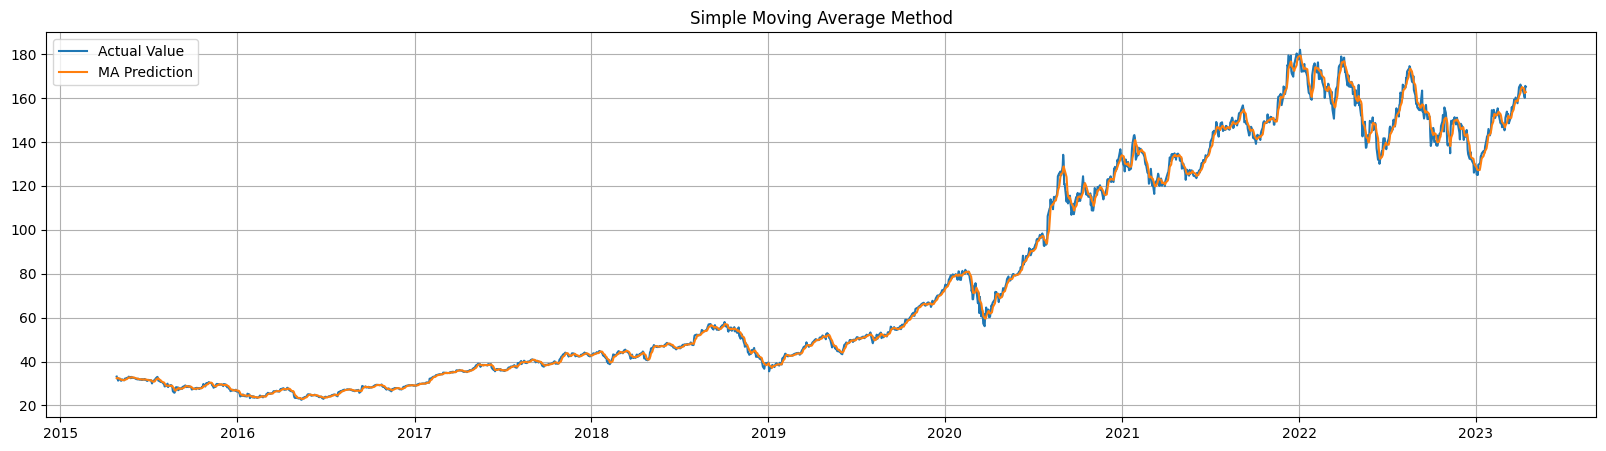

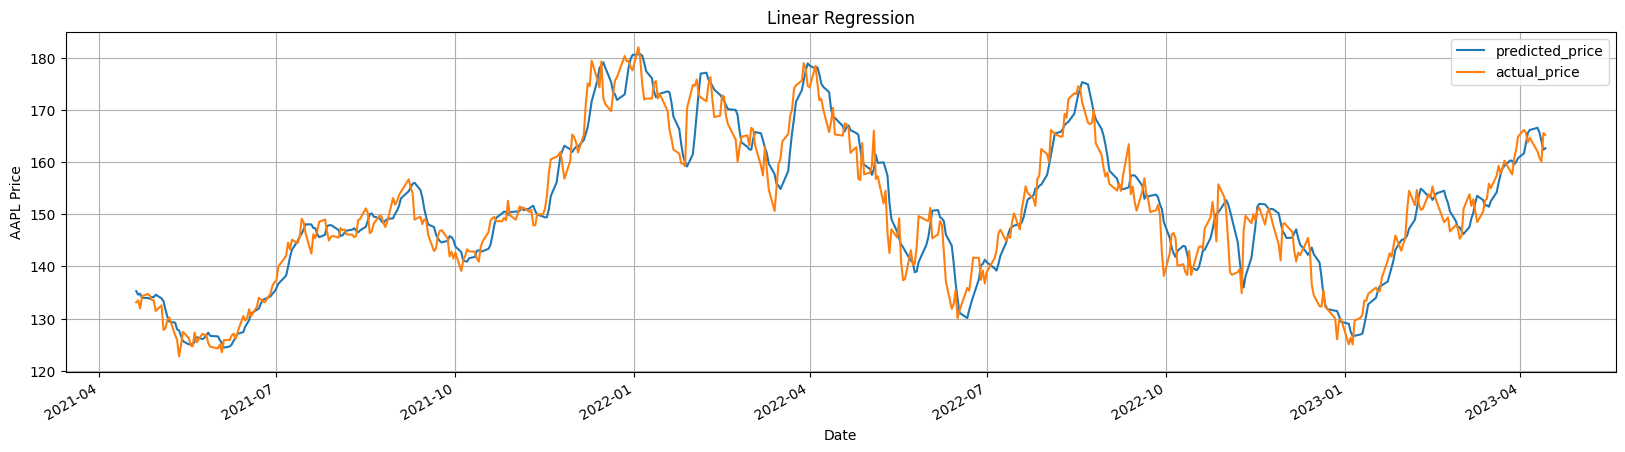

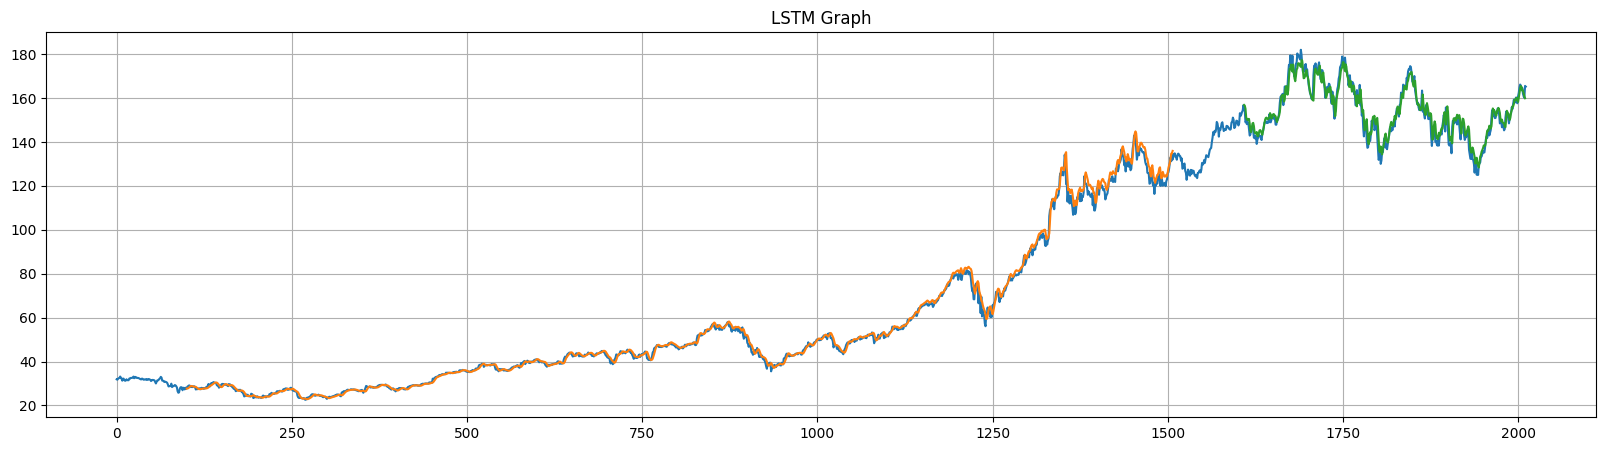

In [ ]:
graphs(graph_sma(df_clean), lr_graph(lr_X_test, lr_y_test, predicted_price), graph_testprediction(train_predict, test_predict, scaler))

### **Calculate absolute error of the three algorithms using the Root Mean Squared**

RMS error is calculated by squaring the differences between actual and predicted values, adding those together, dividing that by the number of test points, and then taking the square root of that result. The lower the value of the Root Mean Squared Error, the better the model is. A perfect model would have a Root Mean Squared Error value of 0.

The RMS has been calculated inside the function of each algorithm right after they where tested and trained. After running the program several times, and as can be seen in the table below, it turns out that LSTM is always the most accurate algorithm. Therefore, LSTM has been the one selected during this project to perform the predictions of future days.

In [ ]:
def rms (sma_rms, lr_rms, lstm_rms):
  sma_rms = str(sma_rms)
  lr_rms = str(lr_rms)
  lstm_rms = str(lstm_rms)

  absError = [["Algorithm", "Absolute Error"], ['Linear Regression', lr_rms], ['Simple Moving Average', sma_rms] , ['LSTM',  lstm_rms]]

  from tabulate import tabulate

  print(tabulate(absError, headers = "firstrow", tablefmt="fancy_grid"))
  


In [ ]:
rms (sma_rms, lr_rms, lstm_rms)

╒═══════════════════════╤══════════════════╕
│ Algorithm             │   Absolute Error │
╞═══════════════════════╪══════════════════╡
│ Linear Regression     │          3.84007 │
├───────────────────────┼──────────────────┤
│ Simple Moving Average │          1.90808 │
├───────────────────────┼──────────────────┤
│ LSTM                  │          0.0222  │
╘═══════════════════════╧══════════════════╛


### **Make the future predictions using LSTM**

In [ ]:
lst_output, day_new, day_pred = prediction_lstm(df1, goal_date, test_data, model)

### **Future Predictions Results**

Once the future predictions are made, they are printed in a table with each respective day. Below the table, the predictions are printed on a graph, so that we can see if the stock value goes up or down. The future predictions are plotted on the chart in orange.

TABLE:
╒═════════════════════╤═════════╕
│   Day of prediction │   Value │
╞═════════════════════╪═════════╡
│                   1 │ 165.061 │
├─────────────────────┼─────────┤
│                   2 │ 164.36  │
├─────────────────────┼─────────┤
│                   3 │ 163.243 │
├─────────────────────┼─────────┤
│                   4 │ 162.332 │
├─────────────────────┼─────────┤
│                   5 │ 161.717 │
├─────────────────────┼─────────┤
│                   6 │ 161.292 │
├─────────────────────┼─────────┤
│                   7 │ 160.939 │
├─────────────────────┼─────────┤
│                   8 │ 160.597 │
├─────────────────────┼─────────┤
│                   9 │ 160.263 │
├─────────────────────┼─────────┤
│                  10 │ 159.957 │
╘═════════════════════╧═════════╛
GRAPH:


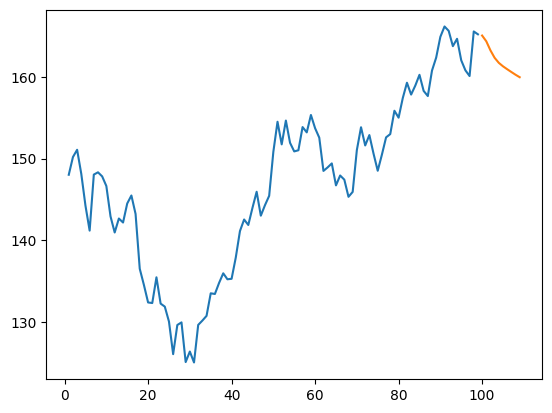

In [ ]:
if lstm_rms < sma_rms and lstm_rms < lr_rms:
  print("TABLE:")
  prediction_table(lst_output)
  print("GRAPH:")
  graph_finalpredictions(df1, lst_output, day_new, day_pred)